<a href="https://colab.research.google.com/github/sonyasavchuk/diploma/blob/main/diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalation

In [ ]:
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


In [ ]:
import plotly.express as px

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import umap

In [ ]:
from sklearn.preprocessing import QuantileTransformer

In [ ]:
import keras
from tensorflow.keras.layers import Input, Dense,Dropout
from tensorflow.keras.models import Model

In [ ]:
import timeit

##Functions

In [ ]:
scaler = StandardScaler()
def scale(desc_dataset,dataset,target,quantile=False):
  scaled_data=scaler.fit_transform(desc_dataset)
  if quantile==True:
    quantile_t=QuantileTransformer()
    scaled_data=quantile_t.fit_transform(scaled_data)
  scaled_df=pd.DataFrame(scaled_data,columns=[i for i in desc_dataset.columns])
  scaled_df[target]=dataset[target]
  return scaled_df

In [ ]:
label_encoder = LabelEncoder()
def labels(scaled_df,target):
  features=scaled_df.iloc[:,:-1]
  labels=scaled_df[target]
  labels_encoded=label_encoder.fit_transform(labels)
  return features,labels,labels_encoded

In [ ]:
def pca_transform(features,labels,target,n=2):
  pca=PCA(n_components=n)
  transformed_data_pca = pca.fit_transform(features)
  transformed_df_pca = pd.DataFrame(transformed_data_pca)
  transformed_df_pca[target] = labels
  return transformed_df_pca

In [ ]:

def lda_transform(features,labels,labels_encoded,target):
  lda=LDA()
  transformed_data_lda = lda.fit_transform(features,labels_encoded)
  transformed_df_lda = pd.DataFrame(transformed_data_lda)
  transformed_df_lda[target]=labels
  return transformed_df_lda

In [ ]:

def tsne_transform(features,labels,target,n=2):
  tsne = TSNE(n_components=n)
  reduced_data_tsne = tsne.fit_transform(features)
  transformed_df_tsne=pd.DataFrame(reduced_data_tsne)
  transformed_df_tsne[target]=labels
  return transformed_df_tsne

In [ ]:

def umap_transform(features,labels,labels_encoded,target,n=2,neighbors=15):
  umap_model = umap.UMAP(n_components=n,n_neighbors=neighbors)
  reduced_data_umap = umap_model.fit_transform(features,labels_encoded)
  transformed_df_umap=pd.DataFrame(reduced_data_umap)
  transformed_df_umap[target]=labels
  return transformed_df_umap

In [ ]:
def encoder_transform(features,labels,target,batch_size=8,epochs=100,n=2):
  input_dim=features.shape[1]
  encoding_dim=n

  if input_dim>40:
    input_data = Input(shape=(input_dim,))
    encoded_x = Dense(64, activation='relu')(input_data)
    encoded_x=Dropout(0.2)(encoded_x)
    encoded_x=Dense(32,activation='relu')(encoded_x)
    encoded_x=Dropout(0.2)(encoded_x)
    encoded_x=Dense(8,activation='relu')(encoded_x)
    encoded=Dense(encoding_dim,activation='relu')(encoded_x)
    decoded_x=Dense(8, activation='relu')(encoded)
    decoded_x=Dropout(0.2)(decoded_x)
    decoded_x=Dense(32, activation='relu')(decoded_x)
    decoded_x=Dropout(0.2)(decoded_x)
    decoded_x=Dense(64, activation='relu')(decoded_x)
    decoded = Dense(input_dim, activation='relu')(decoded_x)
    autoencoder = Model(input_data, decoded)

  if input_dim>16:
    input_data = Input(shape=(input_dim,))
    encoded_x = Dense(16, activation='relu')(input_data)
    encoded_x=Dropout(0.2)(encoded_x)
    encoded_x=Dense(4,activation='relu')(encoded_x)
    encoded=Dense(encoding_dim,activation='relu')(encoded_x)
    decoded_x=Dense(4, activation='relu')(encoded)
    decoded_x=Dropout(0.2)(decoded_x)
    decoded_x=Dense(16, activation='relu')(decoded_x)
    decoded = Dense(input_dim, activation='relu')(decoded_x)
    autoencoder = Model(input_data, decoded)

  elif input_dim>8:
    input_data = Input(shape=(input_dim,))
    encoded_x = Dense(8, activation='relu')(input_data)
    encoded_x=Dropout(0.2)(encoded_x)
    encoded_x=Dense(4,activation='relu')(encoded_x)
    encoded=Dense(encoding_dim,activation='relu')(encoded_x)
    decoded_x=Dense(4, activation='relu')(encoded)
    decoded_x=Dropout(0.2)(decoded_x)
    decoded_x=Dense(8, activation='relu')(decoded_x)
    decoded = Dense(input_dim, activation='relu')(decoded_x)
    autoencoder = Model(input_data, decoded)

  else:
    input_data = Input(shape=(input_dim,))
    encoded_x = Dense(4, activation='relu')(input_data)
    encoded=Dense(encoding_dim,activation='relu')(encoded_x)
    decoded_x=Dense(4, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='relu')(decoded_x)
    autoencoder = Model(input_data, decoded)

  autoencoder.compile(optimizer='adam', loss='mse',metrics='accuracy')
  history=autoencoder.fit(features, features, epochs=epochs, batch_size=batch_size)
  fig,axs=plt.subplots(1,2,figsize=(8,4))
  axs[0].plot(history.history['accuracy'])
  axs[1].plot(history.history['loss'])

  encoder = Model(input_data, encoded)
  reduced_data_autoencoder = encoder.predict(features)
  transformed_df_encoder=pd.DataFrame(reduced_data_autoencoder)
  transformed_df_encoder[target]=labels
  return transformed_df_encoder,encoder

In [ ]:
def different_encoder_transform(encoder,features,labels,target):
  encoder_input_shape = encoder.layers[0].input_shape[0][1]
  features_input_shape=features.shape[1]
  if encoder_input_shape<features_input_shape:
    return features
  n=encoder_input_shape-features_input_shape
  function_features=features.copy()
  for col_name in range(n):
    function_features[f'f{col_name}'] = 0
  reduced_data_autoencoder = encoder.predict(function_features)
  transformed_df_encoder=pd.DataFrame(reduced_data_autoencoder)
  transformed_df_encoder[target]=labels
  return transformed_df_encoder

In [ ]:
def visualize(df,target,alpha=1,n=2):
  targets=df[target].unique()
  colors=plt.cm.get_cmap('Set1',len(targets))
  if len(df.columns)>2:
    if (n==3) and (len(df.columns)>3):
      fig=px.scatter_3d(df,0,1,2,target,opacity=alpha)
      fig.show()

    else:
      for i,tar in enumerate(targets):
        subset=df[df[target]==tar]
        plt.scatter(subset[0],subset[1],color=colors(i),label=tar,alpha=alpha)
        plt.legend();
  else:
    for i, tar in enumerate(targets):
      subset=df[df[target]==tar]
      plt.scatter(subset[0],np.random.uniform(-0.05,0.05,len(subset[0])),color=colors(i),label=tar,alpha=alpha)
      plt.ylim(-1, 1)
      plt.legend();


##Pizza_df

In [ ]:
pizza_df=pd.read_csv('/content/drive/MyDrive/dataset_diploma/Pizza.csv')
pizza_df.shape

(300, 9)

<Axes: >

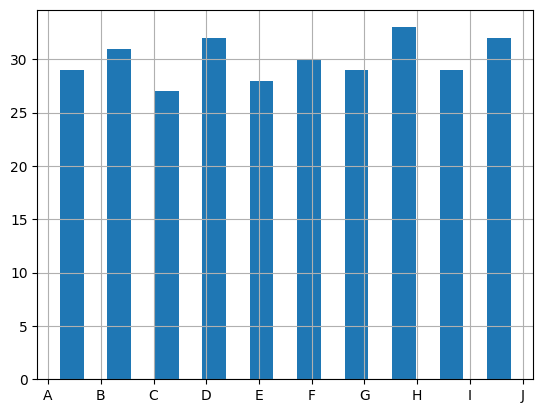

In [ ]:
pizza_df['brand'].hist(rwidth=0.5)

(0.0, 1.0, 0.0, 124.95)

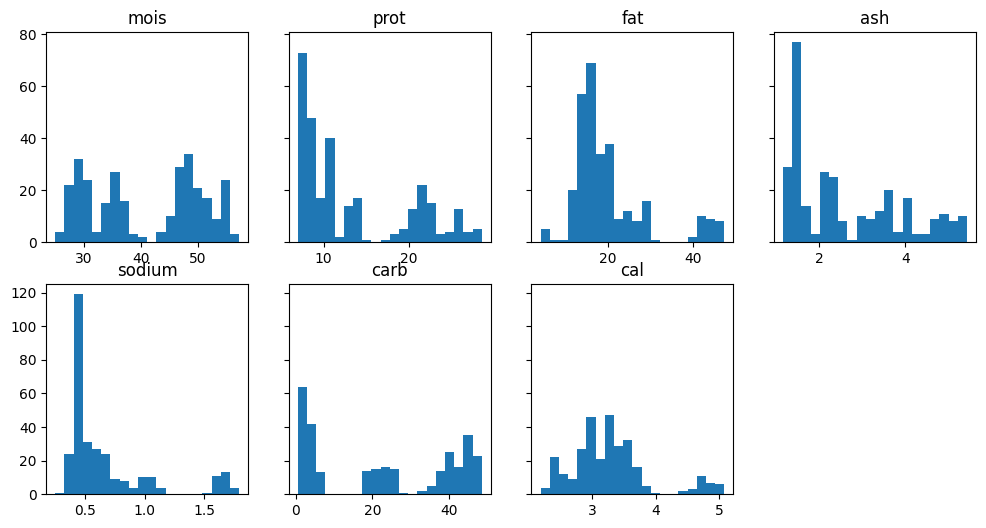

In [ ]:
describers=['mois','prot','fat','ash','sodium','carb','cal']
fig,axs=plt.subplots(2,4,figsize=(12,6),sharey='row')
for i,des in enumerate(describers):
    ax=axs[i // 4, i % 4]
    ax.hist(pizza_df[des],bins=20)
    ax.set_title(des)

axs[1,3].axis('off')


<Axes: >

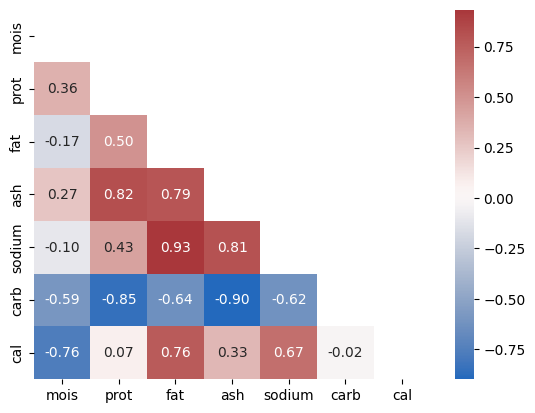

In [ ]:
pizza_subset=pizza_df[describers]
correlation_matrix = pizza_subset.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='vlag', fmt=".2f",
             mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)))

In [ ]:
pizza_scaled=scale(pizza_subset,pizza_df,'brand',quantile=True)
pizza_features,pizza_labels,pizza_labels_encoded=labels(pizza_scaled,'brand')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
  warnings.warn(


In [ ]:
pizza_pca=pca_transform(pizza_features,pizza_labels,'brand',n=2)
visualize(pizza_pca,'brand',n=2)

In [ ]:
pizza_pca=pca_transform(pizza_features,pizza_labels,'brand',n=3)
visualize(pizza_pca,'brand',n=3)

In [ ]:
pizza_lda=lda_transform(pizza_features,pizza_labels,pizza_labels_encoded,'brand')
visualize(pizza_lda,'brand',n=2)

In [ ]:
pizza_lda=lda_transform(pizza_features,pizza_labels,pizza_labels_encoded,'brand')
visualize(pizza_lda,'brand',n=3)

In [ ]:
pizza_tsne=tsne_transform(pizza_features,pizza_labels,'brand',n=3)
visualize(pizza_tsne,'brand',n=3)

In [ ]:
pizza_tsne=tsne_transform(pizza_features,pizza_labels,'brand',n=2)
visualize(pizza_tsne,'brand',n=3)

In [ ]:
pizza_umap=umap_transform(pizza_features,pizza_labels,pizza_labels_encoded,'brand',n=3)
visualize(pizza_umap,'brand',n=3)

In [ ]:
pizza_umap=umap_transform(pizza_features,pizza_labels,pizza_labels_encoded,'brand',n=2)
visualize(pizza_umap,'brand',n=2)

In [ ]:
pizza_encoder_data_2,encoder_pizza_2=encoder_transform(pizza_features,pizza_labels,'brand',epochs=200,n=2)

In [ ]:
pizza_encoder_data_2=different_encoder_transform(loaded_models['encoder_pizza_2'],pizza_features,pizza_labels,'brand')

10/10 [==============================] - 0s 2ms/step


<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=plt.cm.get_cmap('Set1',len(targets))


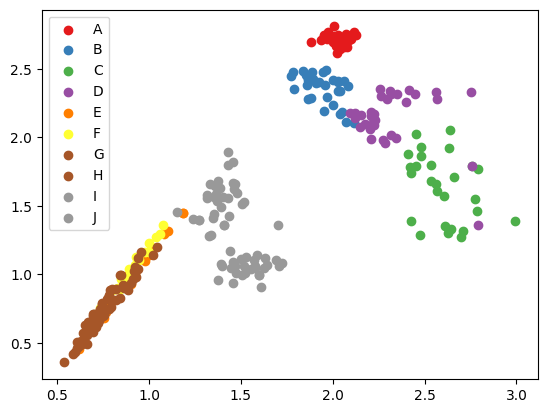

In [ ]:
visualize(pizza_encoder_data_2,'brand',n=2)

In [ ]:
pizza_encoder_data_3,encoder_pizza_3=encoder_transform(pizza_features,pizza_labels,'brand',epochs=200,n=3)

In [ ]:
pizza_encoder_data_3=different_encoder_transform(loaded_models['encoder_pizza_3'],pizza_features,pizza_labels,'brand')

10/10 [==============================] - 0s 2ms/step


In [ ]:
visualize(pizza_encoder_data_3,'brand',n=3)

<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=plt.cm.get_cmap('Set1',len(targets))


##Mushroom_df

In [ ]:
mushroom_df=pd.read_csv('/content/drive/MyDrive/dataset_diploma/mushroom_cleaned.csv')
mushroom_df.head()

cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
0          1372          2                2          10     3.807467   
1          1461          2                2          10     3.807467   
2          1371          2                2          10     3.612496   
3          1261          6                2          10     3.787572   
4          1305          6                2          10     3.711971   

   stem-width  stem-color    season  class  
0        1545          11  1.804273      1  
1        1557          11  1.804273      1  
2        1566          11  1.804273      1  
3        1566          11  1.804273      1  
4        1464          11  0.943195      1

In [ ]:
mushroom_df.shape

(54035, 9)

<Axes: xlabel='class', ylabel='count'>

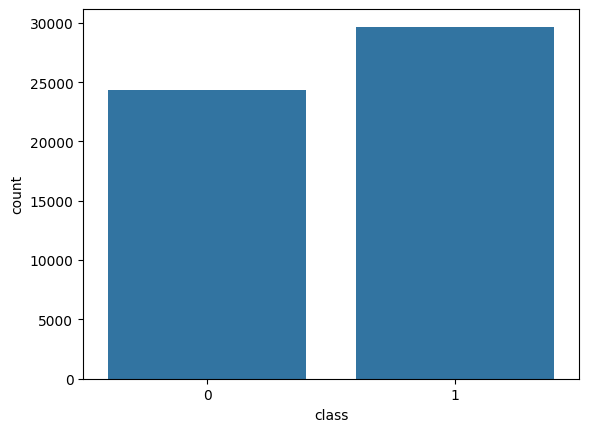

In [ ]:
sns.countplot(data=mushroom_df,x='class')

In [ ]:
mushroom_df.columns

Index(['cap-diameter', 'cap-shape', 'gill-attachment', 'gill-color',
       'stem-height', 'stem-width', 'stem-color', 'season', 'class'],
      dtype='object')

In [ ]:
describers=['cap-diameter', 'cap-shape', 'gill-attachment', 'gill-color',
       'stem-height', 'stem-width', 'stem-color', 'season']
fig,axs=plt.subplots(2,4,figsize=(12,6),sharey='row')
for i,des in enumerate(describers):
    ax=axs[i // 4, i % 4]
    ax.hist(mushroom_df[des],bins=20)
    ax.set_title(des)

In [ ]:
mushroom_subset=mushroom_df[describers]
correlation_matrix = mushroom_subset.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='vlag', fmt=".2f",
             mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)))

In [ ]:
mushroom_scaled=scale(mushroom_subset,mushroom_df,'class')
mushroom_features,mushroom_labels,mushroom_labels_encoded=labels(mushroom_scaled,'class')

In [ ]:
mushroom_pca=pca_transform(mushroom_features,mushroom_labels,'class',n=3)
visualize(mushroom_pca,'class',alpha=0.2,n=3)

In [ ]:
mushroom_pca=pca_transform(mushroom_features,mushroom_labels,'class',n=2)
visualize(mushroom_pca,'class',alpha=0.2,n=2)

In [ ]:
mushroom_lda=lda_transform(mushroom_features,mushroom_labels,mushroom_labels_encoded,'class')
visualize(mushroom_lda,'class',alpha=0.2)

In [ ]:
visualize(mushroom_lda,'class',alpha=0.2,n=3)

In [ ]:
mushroom_tsne=tsne_transform(mushroom_features,mushroom_labels,'class')
visualize(mushroom_tsne,'class')

In [ ]:
mushroom_tsne=tsne_transform(mushroom_features,mushroom_labels,'class',n=3)
visualize(mushroom_tsne,'class',n=3)

In [ ]:
mushroom_umap=umap_transform(mushroom_features,mushroom_labels,mushroom_labels_encoded,'class')
visualize(mushroom_umap,'class')

In [ ]:
mushroom_umap=umap_transform(mushroom_features,mushroom_labels,mushroom_labels_encoded,'class',n=3)
visualize(mushroom_umap,'class',n=3)

In [ ]:
mushroom_encoder_data_2,mushroom_encoder_2=encoder_transform(mushroom_features,mushroom_labels,'class',batch_size=16,epochs=50,n=2)

In [ ]:
mushroom_encoder_data_2=different_encoder_transform(loaded_models['mushroom_encoder_2'],mushroom_features,mushroom_labels,'class')

In [ ]:
visualize(mushroom_encoder_data_2,'class',n=2)

In [ ]:
mushroom_encoder_data_3,mushroom_encoder_3=encoder_transform(mushroom_features,mushroom_labels,'class',batch_size=16,epochs=50,n=3)

In [ ]:
mushroom_encoder_data_3=different_encoder_transform(loaded_models['mushroom_encoder_3'],mushroom_features,mushroom_labels,'class')

1689/1689 [==============================] - 8s 5ms/step


In [ ]:
visualize(mushroom_encoder_data_3,'class',alpha=0.2,n=3)

<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



##cell_phone

In [ ]:
phone_df=pd.read_csv('/content/drive/MyDrive/dataset_diploma/CellPhone_train.csv')
phone_df.head(5)

battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  price_range  
0        0             0     1            1  
1        1             1     0            2  
2        1             1     0            2  
3        1             0     0            2  
4        1             1     0            1  

[5 rows x 21 columns]

In [ ]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

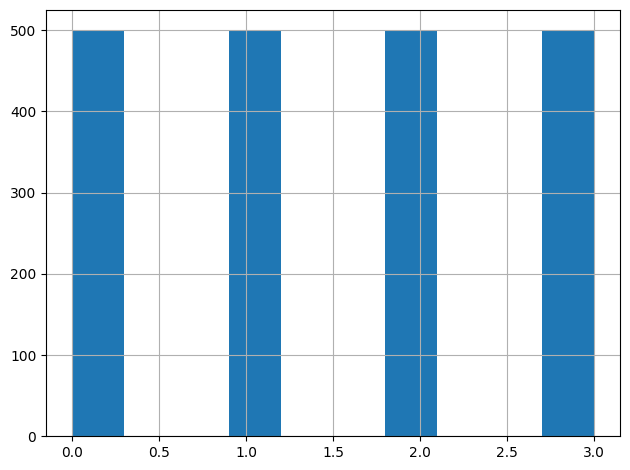

In [ ]:
phone_df['price_range'].hist()
plt.tight_layout();

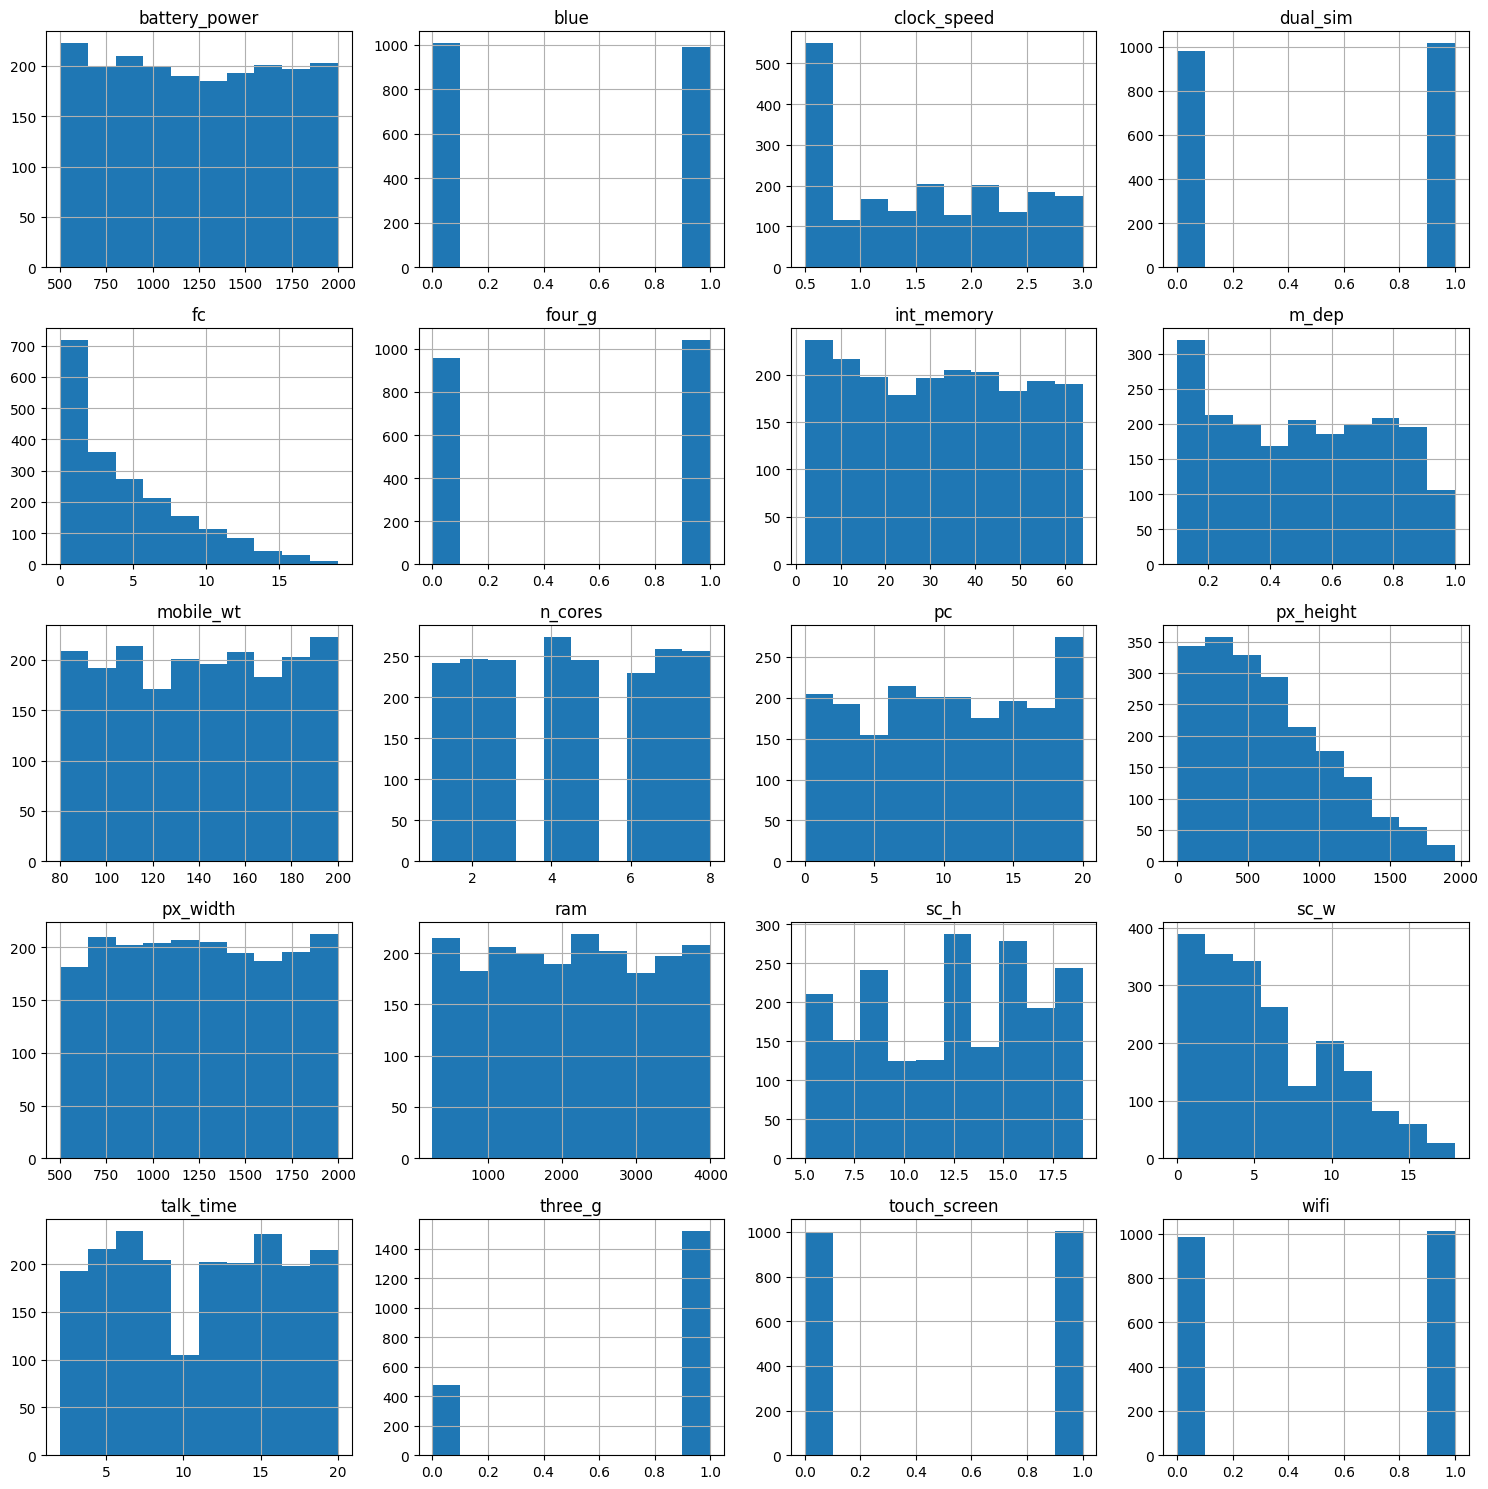

In [ ]:

phone_df.iloc[:,:-1].hist(figsize=(15,15))
plt.tight_layout()

In [ ]:
phone_desc=phone_df.columns[:-1]
phone_subset=phone_df[phone_desc]

<Axes: >

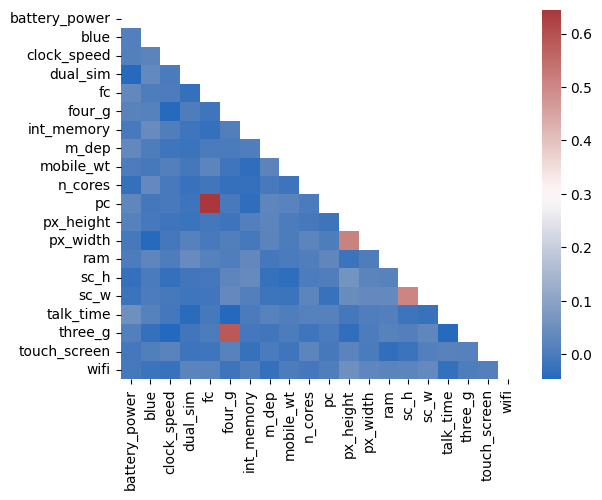

In [ ]:
correlation_matrix = phone_subset.corr()
sns.heatmap(correlation_matrix, cmap='vlag', fmt=".2f",
             mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)))

In [ ]:
phone_scaled=scale(phone_subset,phone_df,'price_range')
phone_features,phone_labels,phone_labels_encoded=labels(phone_scaled,'price_range')

In [ ]:
phone_pca=pca_transform(phone_features,phone_labels,'price_range',n=2)
visualize(phone_pca,'price_range',alpha=0.7,n=2)

In [ ]:
phone_pca=pca_transform(phone_features,phone_labels,'price_range',n=3)
visualize(phone_pca,'price_range',alpha=0.7,n=3)

In [ ]:
phone_lda=lda_transform(phone_features,phone_labels,phone_labels_encoded,'price_range')
visualize(phone_lda,'price_range',n=3)

In [ ]:
visualize(phone_lda,'price_range',n=2)

In [ ]:
phone_umap=umap_transform(phone_features,phone_labels,phone_labels_encoded,'price_range',n=3)
visualize(phone_umap,'price_range',n=3)

<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



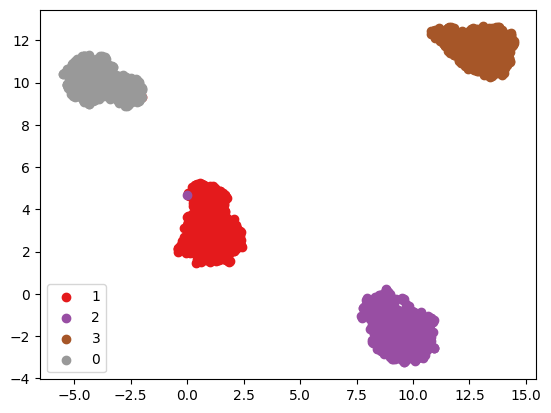

In [ ]:
phone_umap=umap_transform(phone_features,phone_labels,phone_labels_encoded,'price_range',n=2)
visualize(phone_umap,'price_range',n=2)

In [ ]:
phone_tsne=tsne_transform(phone_features,phone_labels,'price_range',n=3)
visualize(phone_tsne,'price_range',n=3)

In [ ]:
phone_tsne=tsne_transform(phone_features,phone_labels,'price_range',n=2)
visualize(phone_tsne,'price_range',n=2)

In [ ]:
phone_encoder_data_2,phone_encoder_2=encoder_transform(phone_features,phone_labels,'price_range',n=2)

In [ ]:
phone_encoder_data_2=different_encoder_transform(loaded_models['phone_encoder_2'],phone_features,phone_labels,'price_range')

In [ ]:
visualize(phone_encoder_data_2,'price_range',n=2)

In [ ]:
phone_encoder_data_3,phone_encoder_3=encoder_transform(phone_features,phone_labels,'price_range',n=3)

In [ ]:
phone_encoder_data_3=different_encoder_transform(loaded_models['phone_encoder_3'],phone_features,phone_labels,'price_range')

In [ ]:
visualize(phone_encoder_data_3,'price_range',n=3)

##House price


In [ ]:
house_df=pd.read_csv('/content/drive/MyDrive/dataset_diploma/house_prices.csv')
house_df.shape

(1460, 81)

In [ ]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
house_df.iloc[:,:45].describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466  
std     161.319273   441.866955   438.705324   386.587738   436.528436  
min       0.000000     0.000000     0.000000   334.000000     0.000000  
25%       0.000000   223.000000   795.750000   882.000000     0.000000  
50%       0.000000   477.500000   991.500000  1087.000000     0.000000  
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000  
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000

In [ ]:
house_df.iloc[:,46:].describe()

GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  \
count  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean   1515.463699      0.425342      0.057534     1.565068     0.382877   
std     525.480383      0.518911      0.238753     0.550916     0.502885   
min     334.000000      0.000000      0.000000     0.000000     0.000000   
25%    1129.500000      0.000000      0.000000     1.000000     0.000000   
50%    1464.000000      0.000000      0.000000     2.000000     0.000000   
75%    1776.750000      1.000000      0.000000     2.000000     1.000000   
max    5642.000000      3.000000      2.000000     3.000000     2.000000   

       BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt  \
count   1460.000000   1460.000000   1460.000000  1460.000000  1379.000000   
mean       2.866438      1.046575      6.517808     0.613014  1978.506164   
std        0.815778      0.220338      1.625393     0.644666    24.689725   
min        0.000000      0.000000      2.000000     0.000000  1900.000000   
25%        2.000000      1.000000      5.000000     0.000000  1961.000000   
50%        3.000000      1.000000      6.000000     1.000000  1980.000000   
75%        3.000000      1.000000      7.000000     1.000000  2002.000000   
max        8.000000      3.000000     14.000000     3.000000  2010.000000   

       ...   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  ...  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean   ...    94.244521    46.660274      21.954110     3.409589    15.060959   
std    ...   125.338794    66.256028      61.119149    29.317331    55.757415   
min    ...     0.000000     0.000000       0.000000     0.000000     0.000000   
25%    ...     0.000000     0.000000       0.000000     0.000000     0.000000   
50%    ...     0.000000    25.000000       0.000000     0.000000     0.000000   
75%    ...   168.000000    68.000000       0.000000     0.000000     0.000000   
max    ...   857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 22 columns]

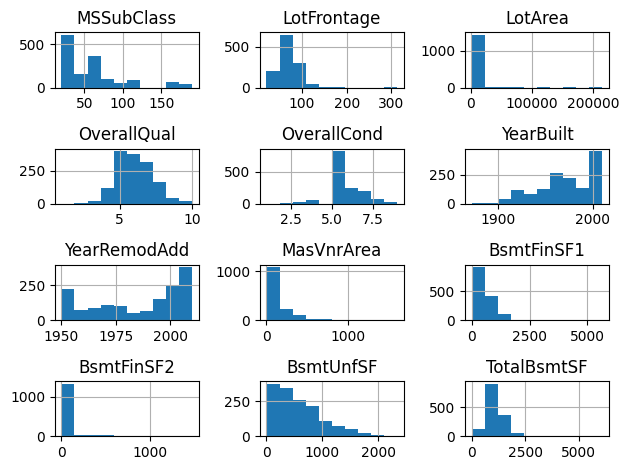

In [ ]:
house_df.iloc[:,1:40].hist();
plt.tight_layout();

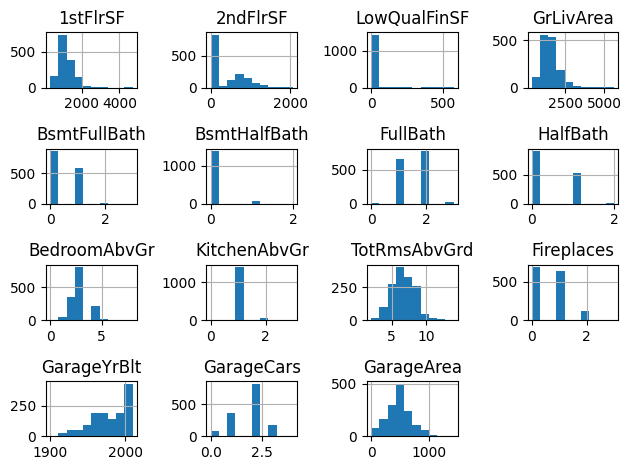

In [ ]:
house_df.iloc[:,41:64].hist();
plt.tight_layout();

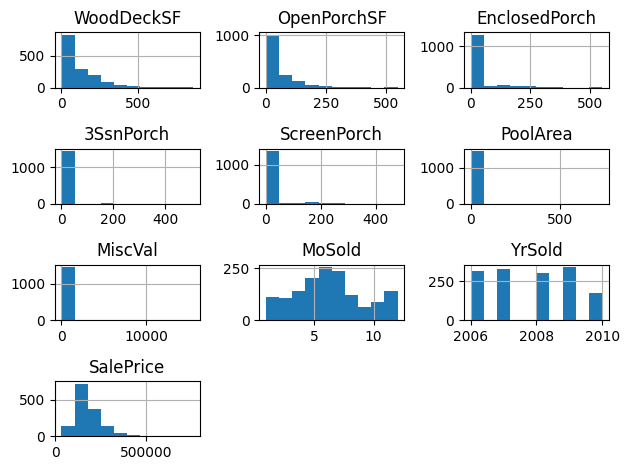

In [ ]:
house_df.iloc[:,65:].hist();
plt.tight_layout();

In [ ]:
columns_with_nan=house_df.isnull().any(axis=0)
columns_with_nan=columns_with_nan[columns_with_nan].index

In [ ]:
house_df[columns_with_nan].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    588 non-null    object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   770 non-null    object 
 11  GarageType    1379 non-null   object 
 12  GarageYrBlt   1379 non-null   float64
 13  GarageFinish  1379 non-null   object 
 14  GarageQual    1379 non-null   object 
 15  GarageCond    1379 non-null   object 
 16  PoolQC        7 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   54 non-null   

In [ ]:
house_df.drop(['Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature'],axis=1,inplace=True)

In [ ]:
columns_with_nan=columns_with_nan.drop(['Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature'])

In [ ]:
columns_with_nan

Index(['LotFrontage', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'],
      dtype='object')

In [ ]:
house_df['GarageCond'].value_counts(),house_df['GarageCond'].describe()

(GarageCond
 TA    1326
 Fa      35
 Gd       9
 Po       7
 Ex       2
 Name: count, dtype: int64,
 count     1379
 unique       5
 top         TA
 freq      1326
 Name: GarageCond, dtype: object)

In [ ]:
fill_values = {'LotFrontage': house_df.LotFrontage.mean(), 'MasVnrArea': 0,'BsmtQual':'missing','BsmtCond':'missing',
               'BsmtExposure':'missing','BsmtFinType1':'missing','BsmtFinType2':'missing','Electrical':'missing','GarageType':'missing',
               'GarageYrBlt':house_df.GarageYrBlt.mean(),'GarageFinish':'missing','GarageQual':'missing','GarageCond':'missing'}
house_df_modified=house_df.fillna(fill_values)

In [ ]:
house_df_modified.isna().sum().sum()

0

In [ ]:
obj_columns=house_df_modified.select_dtypes(include=object)

In [ ]:
for col in obj_columns:
  house_df_modified[col] = label_encoder.fit_transform(house_df_modified[col])

(<Axes: >,
 count      1460.000000
 mean     180921.195890
 std       79442.502883
 min       34900.000000
 25%      129975.000000
 50%      163000.000000
 75%      214000.000000
 max      755000.000000
 Name: SalePrice, dtype: float64)

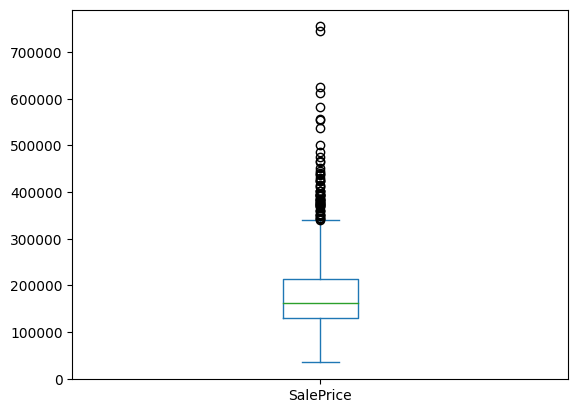

In [ ]:
house_df_modified.SalePrice.plot(kind='box'),house_df_modified.SalePrice.describe()

In [ ]:
bins = [0, np.quantile(house_df_modified.SalePrice, 0.25), np.quantile(house_df_modified.SalePrice, 0.5),np.quantile(house_df_modified.SalePrice, 0.75), float('inf')]
bin_labels = ['cheap', 'normal', 'expensive','overpriced']

house_df_modified['SalePrice'] = pd.cut(house_df_modified['SalePrice'], bins=bins, labels=bin_labels, include_lowest=True)

In [ ]:
house_df_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   int64   
 2   MSZoning       1460 non-null   int64   
 3   LotFrontage    1460 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   int64   
 6   LotShape       1460 non-null   int64   
 7   LandContour    1460 non-null   int64   
 8   Utilities      1460 non-null   int64   
 9   LotConfig      1460 non-null   int64   
 10  LandSlope      1460 non-null   int64   
 11  Neighborhood   1460 non-null   int64   
 12  Condition1     1460 non-null   int64   
 13  Condition2     1460 non-null   int64   
 14  BldgType       1460 non-null   int64   
 15  HouseStyle     1460 non-null   int64   
 16  OverallQual    1460 non-null   int64   
 17  OverallCond    1460 non-null   in

<Axes: xlabel='SalePrice', ylabel='count'>

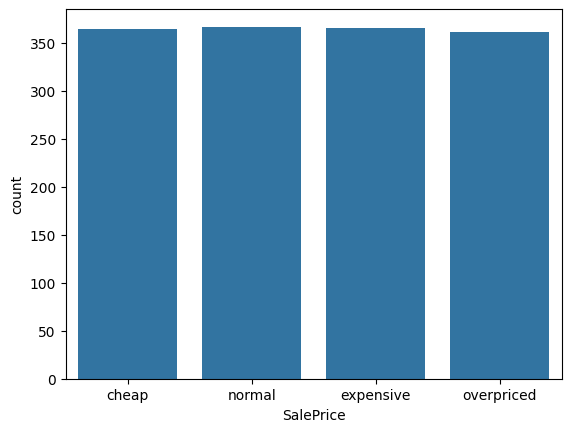

In [ ]:
sns.countplot(data=house_df_modified,x='SalePrice')

In [ ]:
desc=house_df_modified.columns[1:-1]
house_subset=house_df_modified[desc]

In [ ]:
house_scale=scale(house_subset,house_df_modified,'SalePrice',quantile=True)
house_features,house_labels,house_labels_encoded=labels(house_scale,'SalePrice')

In [ ]:
house_pca=pca_transform(house_features,house_labels,'SalePrice',n=3)
visualize(house_pca,'SalePrice',n=3)

In [ ]:
house_pca=pca_transform(house_features,house_labels,'SalePrice')
visualize(house_pca,'SalePrice')

In [ ]:
house_lda=lda_transform(house_features,house_labels,house_labels_encoded,'SalePrice')
visualize(house_lda,'SalePrice',n=3)

In [ ]:
house_lda=lda_transform(house_features,house_labels,house_labels_encoded,'SalePrice')
visualize(house_lda,'SalePrice')

In [ ]:
house_umap=umap_transform(house_features,house_labels,house_labels_encoded,'SalePrice',3,15)
visualize(house_umap,'SalePrice',n=3)

<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



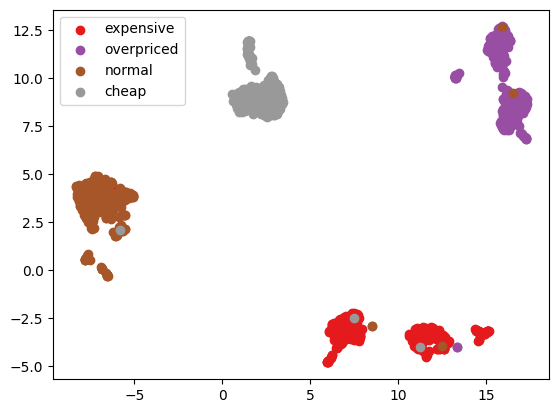

In [ ]:
house_umap=umap_transform(house_features,house_labels,house_labels_encoded,'SalePrice',2,15)
visualize(house_umap,'SalePrice',n=2)

In [ ]:
house_tsne=tsne_transform(house_features,house_labels,'SalePrice',n=3)
visualize(house_tsne,'SalePrice',n=3)

In [ ]:
house_tsne=tsne_transform(house_features,house_labels,'SalePrice',n=2)
visualize(house_tsne,'SalePrice',n=2)

In [ ]:
house_encoder_data_3,house_encoder_3=encoder_transform(house_features,house_labels,'SalePrice',epochs=30,batch_size=8,n=3)

In [ ]:
house_encoder_data_2=different_encoder_transform(loaded_models['house_encoder_2'],house_features,house_labels,'SalePrice')

In [ ]:
house_encoder_data_3=different_encoder_transform(loaded_models['house_encoder_3'],house_features,house_labels,'SalePrice')

In [ ]:
visualize(house_encoder_data_3,'SalePrice',alpha=0.5,n=3)

In [ ]:
house_encoder_data_2,house_encoder_2=encoder_transform(house_features,house_labels,'SalePrice',epochs=30,batch_size=8,n=2)

In [ ]:
house_encoder_2.save('house_encoder_2.keras')

In [ ]:
visualize(house_encoder_data_2,'SalePrice',alpha=0.5,n=2)

##Load models

In [ ]:
models = ["encoder_pizza_2", "encoder_pizza_3", "phone_encoder_2", "phone_encoder_3", "mushroom_encoder_2", "mushroom_encoder_3","house_encoder_2","house_encoder_3"]
loaded_models = {}

for mod in models:
  loaded_models[mod] = keras.models.load_model(f'/content/{mod}.keras')

In [ ]:
loaded_models

{'encoder_pizza_2': <keras.src.engine.functional.Functional at 0x792be8cdbb50>,
 'encoder_pizza_3': <keras.src.engine.functional.Functional at 0x792be8d17970>,
 'phone_encoder_2': <keras.src.engine.functional.Functional at 0x792be8cda9e0>,
 'phone_encoder_3': <keras.src.engine.functional.Functional at 0x792be5aedcc0>,
 'mushroom_encoder_2': <keras.src.engine.functional.Functional at 0x792be5b10cd0>,
 'mushroom_encoder_3': <keras.src.engine.functional.Functional at 0x792be5b13b20>,
 'house_encoder_2': <keras.src.engine.functional.Functional at 0x792be5b2e920>,
 'house_encoder_3': <keras.src.engine.functional.Functional at 0x792be5ad7ca0>}

#using other encoder models to pizza df

10/10 [==============================] - 0s 2ms/step


<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



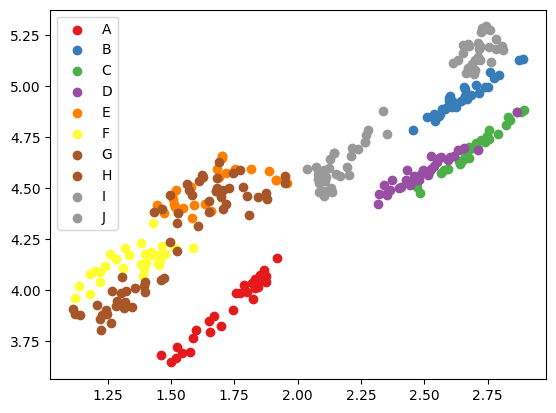

In [ ]:
pizza_encoded_by_mushroom_2=different_encoder_transform(loaded_models['mushroom_encoder_2'],pizza_features,pizza_labels,'brand')
visualize(pizza_encoded_by_mushroom_2,'brand')

In [ ]:
pizza_encoded_by_mushroom_3=different_encoder_transform(loaded_models['mushroom_encoder_3'],pizza_features,pizza_labels,'brand')

10/10 [==============================] - 0s 2ms/step


In [ ]:
visualize(pizza_encoded_by_mushroom_3,'brand',n=3)

<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



10/10 [==============================] - 0s 2ms/step


<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



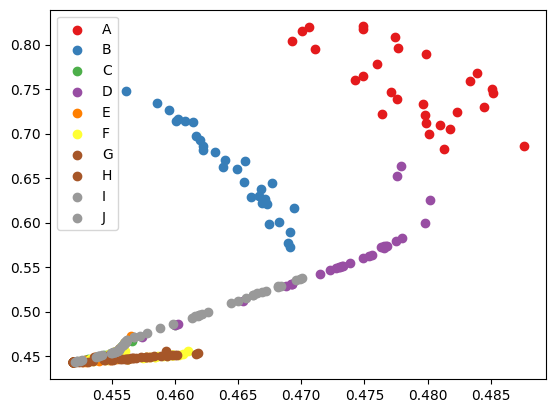

In [ ]:
pizza_encoded_by_phone_2=different_encoder_transform(loaded_models['phone_encoder_2'],pizza_features,pizza_labels,'brand')
visualize(pizza_encoded_by_phone_2,'brand')

In [ ]:
pizza_encoded_by_phone_3=different_encoder_transform(loaded_models['phone_encoder_3'],pizza_features,pizza_labels,'brand')
visualize(pizza_encoded_by_phone_3,'brand',n=3)

10/10 [==============================] - 0s 2ms/step


<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



10/10 [==============================] - 0s 2ms/step


<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



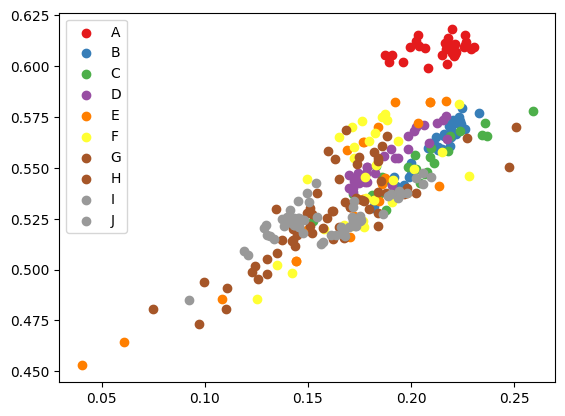

In [ ]:
pizza_encoded_by_house_2=different_encoder_transform(loaded_models['house_encoder_2'],pizza_features,pizza_labels,'SalePrice')
visualize(pizza_encoded_by_house_2,'SalePrice')

In [ ]:
pizza_encoded_by_house_3=different_encoder_transform(loaded_models['house_encoder_3'],pizza_features,pizza_labels,'SalePrice')
visualize(pizza_encoded_by_house_3,'SalePrice',n=3)

10/10 [==============================] - 0s 2ms/step


<ipython-input-16-45230efda2ca>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



#Classification model using different dimensionality reduction techniques

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
def comparise(dat):
  features,label,labels_encoded=labels(dat,'SalePrice')
  X_train, X_test, y_train, y_test = train_test_split(features,labels_encoded, test_size=0.2, random_state=42)

  gnb = GaussianNB()
  gnb_time = timeit.timeit(lambda: gnb.fit(X_train, y_train), number=100)

  gnb.fit(X_train, y_train)

  svm_linear = SVC(kernel='linear')
  svm_time = timeit.timeit(lambda: svm_linear.fit(X_train, y_train), number=100)
  svm_linear.fit(X_train, y_train)

  y_pred_gnb = gnb.predict(X_test)
  y_pred_svm = svm_linear.predict(X_test)
  accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
  accuracy_svm = accuracy_score(y_test, y_pred_svm)
  return {
        'gnb': {
            'accuracy': round(accuracy_gnb,3),
            'training_time': round(gnb_time,3)
        },
        'svm': {
            'accuracy': round(accuracy_svm,3),
            'training_time': round(svm_time,3)
        }
  }


In [ ]:
for i,dat in enumerate(datasets):
  print (i,dat.shape)

0 (1460, 74)
1 (1460, 4)
2 (1460, 4)
3 (1460, 4)
4 (1460, 4)
5 (1460, 4)


In [ ]:
house_data_encoder_2=different_encoder_transform(loaded_models['house_encoder_2'],house_features,house_labels,'SalePrice')
house_data_encoder_3=different_encoder_transform(loaded_models['house_encoder_3'],house_features,house_labels,'SalePrice')

46/46 [==============================] - 0s 2ms/step


In [ ]:
results={}
datasets=[house_scale,house_pca,house_lda,house_umap,house_tsne,house_data_encoder_3]

for i,dat in enumerate(datasets):
  results[get_var_name(dat)]=comparise(dat)



In [ ]:
results

{'house_scale': {'gnb': {'accuracy': 0.62, 'training_time': 0.47},
  'svm': {'accuracy': 0.795, 'training_time': 5.617}},
 'house_pca': {'gnb': {'accuracy': 0.678, 'training_time': 0.168},
  'svm': {'accuracy': 0.726, 'training_time': 1.814}},
 'house_lda': {'gnb': {'accuracy': 0.832, 'training_time': 0.172},
  'svm': {'accuracy': 0.846, 'training_time': 2.481}},
 'house_umap': {'gnb': {'accuracy': 0.997, 'training_time': 0.247},
  'svm': {'accuracy': 0.997, 'training_time': 1.743}},
 'house_tsne': {'gnb': {'accuracy': 0.589, 'training_time': 0.274},
  'svm': {'accuracy': 0.572, 'training_time': 38.557}},
 'house_data_encoder_3': {'gnb': {'accuracy': 0.644, 'training_time': 0.173},
  'svm': {'accuracy': 0.651, 'training_time': 3.633}}}

#Save models

In [ ]:
def get_var_name(abr):
    for name, value in globals().items():
        if value is abr:
            return name

In [ ]:
#encoder_pizza_2,encoder_pizza_3,phone_encoder_2,phone_encoder_3,mushroom_encoder_2,mushroom_encoder_3,house_encoder_2,house_encoder_3

In [ ]:
models=[]
for mod in models:
  variable_name = get_var_name(mod)
  mod.save(f'{variable_name}.keras')